---
title: |
  Feature Maps, Regularization, and Generalization
author: Phil Chodrow
bibliography: ../refs.bib
format:
  html:
    code-fold: false
    cache: true
    callout-appearance: minimal
    cap-location: margin
---

::: {.hidden}
$$
\newcommand{\R}{\mathbb{R}}
\newcommand{\mathbf{x}}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vz}{\mathbf{z}}
\newcommand{\vd}{\mathbf{d}}
\newcommand{\mathbf{X}}{\mathbf{X}}
\newcommand{\mR}{\mathbf{R}}
\newcommand{\mathbf{w}}{\mathbf{w}}
\newcommand{\mathbf{r}}{\mathbf{r}}
\newcommand{\vzero}{\mathbf{0}}
\newcommand{\bracket}[1]{\langle #1 \rangle}
\newcommand{\paren}[1]{\left( #1 \right)}
\newcommand{\one}[1]{\mathbb{1}\left[ #1 \right]}
\newcommand{\cL}{\mathcal{L}}
\newcommand{\cD}{\mathcal{D}}
\newcommand{\cM}{\mathcal{M}}
\newcommand{\mA}{\mathbf{A}}
\newcommand{\vtheta}{\boldsymbol{\theta}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\lvert #1 \rvert}
\newcommand{\prob}[1]{\mathbb{P}\left[#1\right]}
\newcommand{\E}{\mathbb{E}}
\newcommand{\dd}[2]{\frac{\partial #1}{\partial #2}}

\usepackage{amsmath}
\DeclareMathOperator*{\argmax}{argmax\;}
\DeclareMathOperator*{\argmin}{argmin\;}
$$

In [1]:
#| echo: false
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

:::

# Quick Recap

[Last time](23-gradient-descent.ipynb), we considered the problem of learning a classification model via gradient descent to solve an *empirical risk minimization* problem. We assumed that we had data, a pair $(\mathbf{X}, \vy)$ where

- $\mathbf{X} \in \R^{n\times p}$ is the *feature matrix*. There are $n$ distinct observations, encoded as rows. Each of the $p$ columns corresponds to a *feature*: something about each observation that we can measure or infer. Each observation is written $\mathbf{x}_1, \mathbf{x}_2,\ldots$.
$$
\mathbf{X} = \left[\begin{matrix} & - & \mathbf{x}_1 & - \\
& - & \mathbf{x}_2 & - \\
& \vdots & \vdots & \vdots \\
& - & \mathbf{x}_{n} & - \end{matrix}\right]
$$
- $\vy \in \R^{n}$ is the *target vector*. The target vector gives a label, value, or outcome for each observation.

Using this data, we defined the empirical risk minimization problem, which had the general form
$$
\hat{\mathbf{w}} = \argmin_{\mathbf{w}} \; L(\mathbf{w})\;,
$${#eq-empirical-risk-minimization}
where
$$
L(\mathbf{w}) = \frac{1}{n} \sum_{i = 1}^n \ell(\bracket{\mathbf{w}, \mathbf{x}_i}, y_i)\;.
$$

In our [last lecture](23-gradient-descent.ipynb), we studied how to compute the gradient of $L(\mathbf{w})$ in minimize the empirical risk and find a good value $\hat{\mathbf{w}}$ for the parameter vector. In this lecture we're going to assume that we can cheerfully solve the empirical risk minimization for convex linear models.

## Nonlinear Decision Boundaries

However, we are still working with an important limitation: for a long time now, we've focused only on *linear* decision boundaries. However, most of the data we care about in practice has *nonlinear* decision boundaries. Here's a dramatic example. [For this example and throughout today, I'm using the implementation of logistic regression from `scikit-learn`. The purpose is to let you follow along while still giving you the chance to implement your own logistic regression for homework. Toward the end of the notes, I'll highlight where regularization shows up if you want to implement it in e.g. a `torch` model. I'm also using the `plot_decision_regions` function from the `mlxtend` package, which is a handy plotting utility for visualizing the behavior of our models.]{.alert}

In [2]:
#| code-fold: true

from sklearn.datasets import make_moons, make_circles
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import numpy as np

def viz_decision_regions(model, X_train, y_train, X_test, y_test):
    fig, ax = plt.subplots(1, 2, figsize = (8, 3.5), sharex = True, sharey = True)

    for i, data in enumerate(["Train", "Test"]):
        X = [X_train, X_test][i]
        y = [y_train, y_test][i]
        plot_decision_regions(X, y, clf = model, ax = ax[i])
        score = ax[i].set_title(f"{data}ing accuracy = {model.score(X, y)}")
        ax[i].set(xlabel = r"$x_1$")
        if i == 0:
            ax[i].set(ylabel = r"$x_2$")

def plot_weights(plr):
    coefs        = plr.named_steps["LR"].coef_.flatten()
    frac_zero    = np.isclose(coefs, 0).mean()
    mean_coef    = np.abs(coefs).mean()
    coefs_sorted = np.sort(coefs)
    plt.scatter(np.arange(len(coefs)), coefs_sorted, s = 10, facecolors = "none", edgecolors = "black")
    plt.gca().set(xlabel = "weight (sorted)", ylabel = "weight value", title = fr"Mean $|w_i|$ = {mean_coef:.2f}, zero weights = {100*frac_zero:.0f}%")

In [3]:
#| echo: false
#| include: false
plt.style.use('seaborn-v0_8-whitegrid')
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

First, let's create some training and testing data:

In [4]:
X_train, y_train = make_circles(200, shuffle = True, noise = 0.1, factor = 0.5)
X_test, y_test   = make_circles(200, shuffle = True, noise = 0.1, factor = 0.5)

Now let's fit and visualize the the decision regions learned on both the training and test sets.

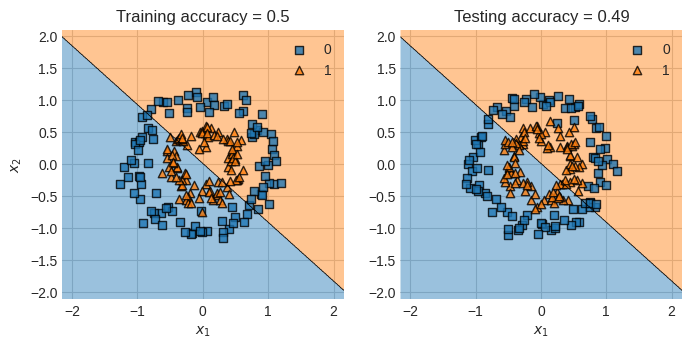

In [5]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

viz_decision_regions(LR, X_train, y_train, X_test, y_test)

Yikes!

Visually this *should* be pretty easy data to classify. But the linear decision boundary clearly isn't the way.

::: {.callout-important}

Given a point $\mathbf{x}$, what information would you find most useful about that point in determining whether it should have label $0$ or $1$ based on this training data?
:::

## Feature Maps

Suppose that we were able to extract from each point its distance from the origin. In 2d, we could take a point $\mathbf{x}$ and simply compute

$$
r^2 = x_1^2 + x_2^2\;.
$$

We could then make the classification based on the value of $r^2$. In this data set, it looks like the classification rule that predicts $1$ if $r^2 < 1$ and $0$ otherwise would be a pretty good one. The important insight here is that this is *also* a linear model, with linear predictor function

$$
\hat{y} = \bracket{\mathbf{w}, \phi(\mathbf{x})}\;,
$$

and predicted labels $\mathbb{1}[\hat{y} < 0]$.

where $\phi(\mathbf{x}) = (r^2, 1)$ and $\mathbf{w} = (1, -1)$. We could attempt to find a value of the weight vector close to this one using empirical risk minimization using our standard methods. This means that we can use empirical risk minimization for this problem if we just transform the features $\mathbf{X}$ first! We need to compute a matrix $\mR$ whose $i$th row is $\mathbf{r}_i = \phi(\mathbf{x}) = (r^2_i, 1) = (x_{i1}^2 + x_{i2}^2, 1)$, and then use this matrix in place of $\mathbf{X}$ for our classification task.

The transformation $\phi: (x_1, x_2) \mapsto (x_1^2 + x_2^2, 1)$ is an example of a *feature map*.

::: {.callout-note}
::: {#def-feature-map}

Let $\mathbf{X} \in \R^{n \times q}$. A *feature map* $\phi$ is a function $\phi:\R^q \rightarrow \R^q$, We call $\phi(\mathbf{x}) in \R^p$ the *feature vector* corresponding to $\mathbf{x}$.  For a given feature map $\phi$, we define the map $\Phi:\R^{n \times q} \rightarrow \R^{n\times p}$ as

$$
\Phi(\mathbf{X}) = \left(\begin{matrix}
     - & \phi(\mathbf{x}_1) & - \\
     - & \phi(\mathbf{x}_2) & - \\
     \vdots & \vdots & \vdots \\
     - & \phi(\mathbf{x}_n) & - \\
\end{matrix}\right)
$$

:::
:::

## Feature Maps and Linear Separability

We often think of feature maps as taking us from a space in which the data is **not** linearly separable to a space in which it is (perhaps approximately). For example, consider the feature map

$$
\phi: (x_1, x_2) \mapsto (x_1^2, x_2^2)\;.
$$

This map is sufficient to express the radius information, since we can represent the radius as

$$
r^2 = \bracket{(1, 1), (x_1^2, x_2^2)}\;.
$$

Let's see how this looks. We'll again show the failed linear separator, and we'll also show a successful separator in a transformed feature space:

In [6]:
def phi(X):
    return X**2

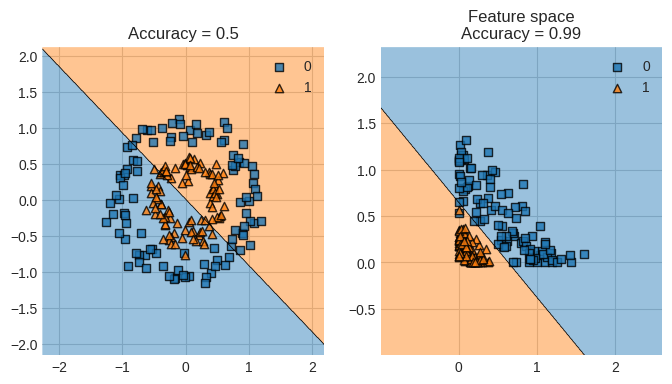

In [7]:
#| code-fold: true
fig, axarr = plt.subplots(1, 2, figsize=(8, 4))

plot_decision_regions(X_train, y_train, clf = LR, ax = axarr[0])
score = axarr[0].set_title(f"Accuracy = {LR.score(X_train, y_train)}")

X_ = phi(X_train)
LR2 = LogisticRegression()
LR2.fit(X_, y_train)
plot_decision_regions(X_, y_train, clf = LR2, ax = axarr[1])
score = axarr[1].set_title(f"Feature space\nAccuracy = {LR2.score(X_, y_train)}")

Just by fitting the logistic regression model in the feature space, we were able to go from essentially random accuracy to accuracy of nearly 100% on training data.

## Feature Maps in Practice

Going back to our example of trying to classify the two nested circles, we could just compute the radius. In practice, however, we don't really know which features are going to be most useful, and so we just compute *a set* of features. In our case, the square of the radius is an example of a polynomial of degree 2:
$$
r^2 = x_1^2 + x_2^2\;.
$$

Instead of just assuming that the radius is definitely the right thing to compute, we more frequently just compute all the monomials of degree 2 or lower. If $\mathbf{x} = (x_1, x_2)$, then the vector of all monomials of degree up to 2 is

$$
\phi(\mathbf{x}_i) = (1, x_1, x_2, x_1^2, x_2^2, x_1x_2)\;.
$$

We then use a linear model to solve the empirical risk minimization problem

$$
\hat{\mathbf{w}} = \argmin_{w} \sum_{i = 1}^n \ell(\bracket{\mathbf{w}, \phi(\mathbf{x}_i)}, y_i)\;.
$$

The important point to keep track of is that the new feature matrix $\mathbf{X}' = \Phi(\mathbf{X})$ generally has a different number of columns from $\mathbf{X}$. In this case, for example, $\mathbf{X}$ had just 2 columns but $\Phi(\mathbf{X})$ has 6. This means that $\hat{\mathbf{w}}$ has 6 components, instead of 2!

Let's now run logistic regression with degree-2 polynomial features on this data set. The most convenient way to make this happen in the `scikit-learn` framework is with at `Pipeline`. The `Pipeline` first applies the feature map and then calls the model during both fitting and evaluation. We'll wrap the pipeline in a simple function for easy reuse.

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def poly_LR(degree, **kwargs):
    plr = Pipeline([("poly", PolynomialFeatures(degree = degree)),
                    ("LR", LogisticRegression(**kwargs))])
    return plr

Now our decision boundary is much more successful:

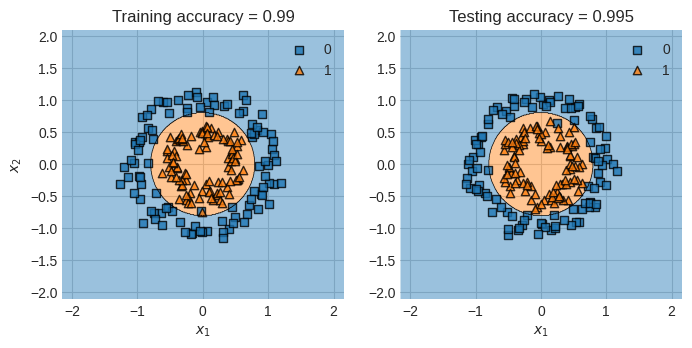

In [9]:
plr = poly_LR(degree = 2)
plr.fit(X_train, y_train)
viz_decision_regions(plr, X_train, y_train, X_test, y_test)

Let's check the entries of the weight vector:

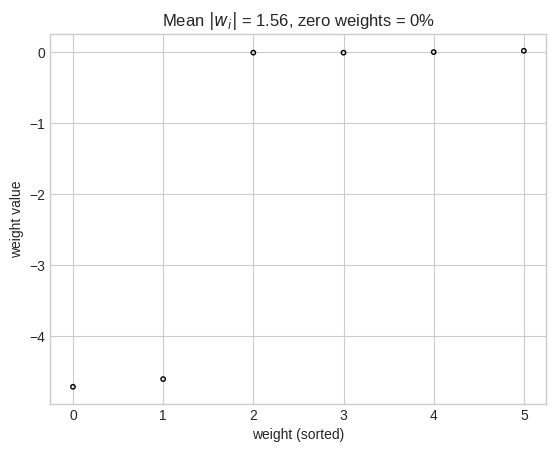

In [10]:
plot_weights(plr)

Notice that two coefficients are much larger in magnitude than the others, and approximately equal. These are the coefficients for the features $x_1^2$ and $x_2^2$. The fact that these are approximately equal means that our model is very close to using the square radius $r^2 = x_1^2 + x_2^2$ as a learned feature for this data, just like we'd expect. The benefit is that we didn't have to hard-code that in; the model just detected the right pattern to find.

Part of the reason this might be beneficial is that for some data sets, we might not really know what specific features we should try. For example, here's another one where a linear classifier doesn't do so great (degree 1 corresponds to no transformation of the features). We'll keep using this example as we go, and so we'll generate both a training and a test set.  

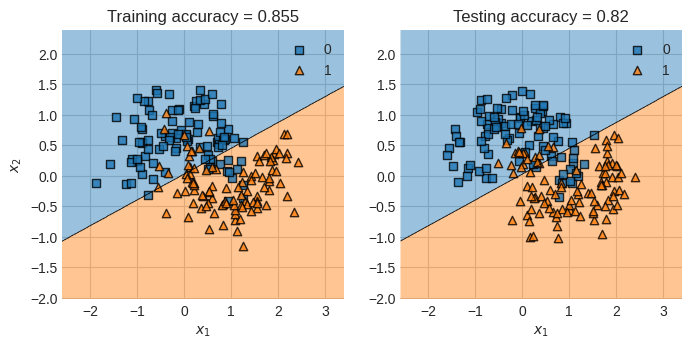

In [12]:
np.random.seed(123)
X_train, y_train = make_moons(200, shuffle = True, noise = 0.3)
X_test, y_test   = make_moons(200, shuffle = True, noise = 0.3)

plr = poly_LR(degree = 1)
plr.fit(X_train, y_train)


viz_decision_regions(plr, X_train, y_train, X_test, y_test)

It's not as obvious that we should use the radius or any other specific feature for our feature map. Fortunately we don't need to think too much about it -- we can just increase the degree and let the model figure things out:

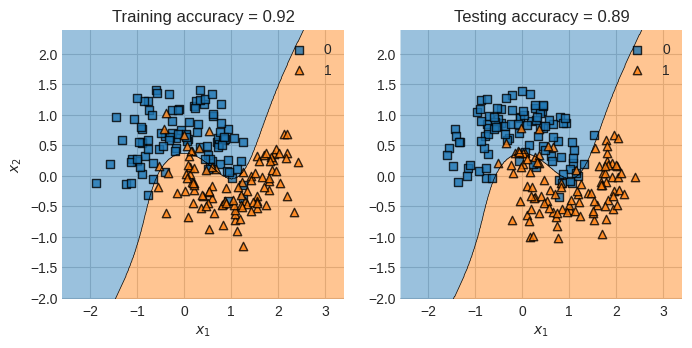

In [19]:
plr = poly_LR(degree = 5)
plr.fit(X_train, y_train)

viz_decision_regions(plr, X_train, y_train, X_test, y_test)

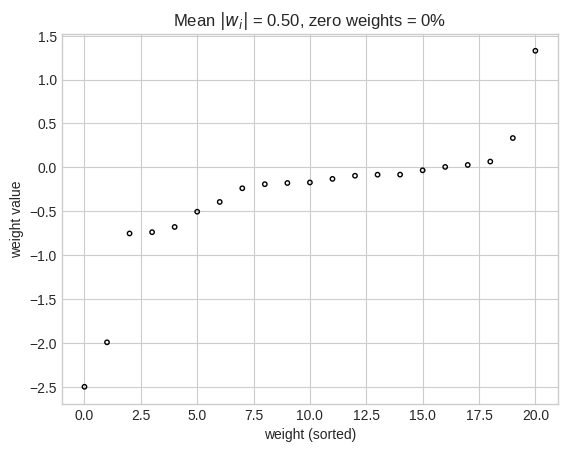

In [20]:
plot_weights(plr)

Much nicer!

## Generalization, Feature Selection, Regularization

So, why don't we just use as many features as it takes to get perfect accuracy on the training data? As usual, this would lead to overfitting, as we can observe in the following example:

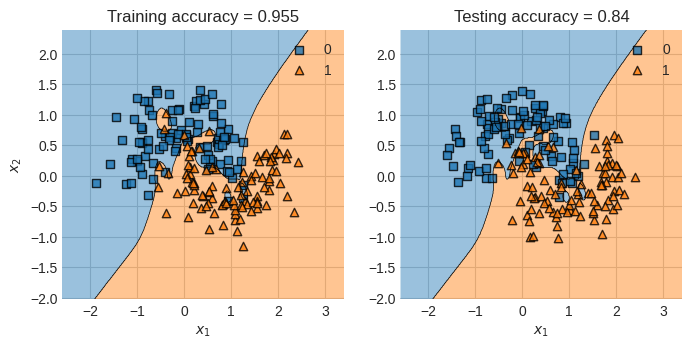

In [21]:
plr = poly_LR(degree = 15, penalty = None, max_iter = 1000000)
plr.fit(X_train, y_train)


viz_decision_regions(plr, X_train, y_train, X_test, y_test)

[I've had to change some parameters to the `LogisticRegression` in order to ensure that it fully ran the optimization procedure for this many polynomials.]{.aside}

The problem here is that, although this classifier might achieve perfect *training* accuracy, it doesn't really look like it's captured "the right" pattern. This is why this classifier makes many more mistakes on the test data, even though it had much higher training accuracy. We have *overfit*: our model was so flexible that it was able to learn both some *real* patterns that we wanted it to learn and some *noise* that we didn't. As a result, when it made a prediction on new data, the model's predictions were imperfect, reflecting the noise it learned in the training process.

In machine learning practice, we don't actually *want* our models to get perfect scores on the training data -- we want them to ***generalize*** to new instances of unseen data. Overfitting is one way in which a model can fail to generalize.

Let's do an experiment in which we see what happens to the model's generalization ability when we increase the number of polynomial features:


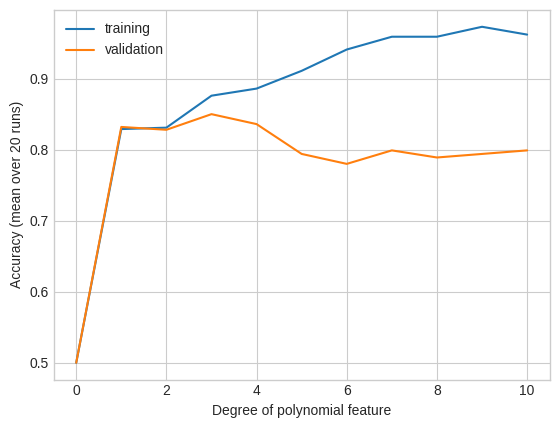

In [22]:
#| code-fold: true

import pandas as pd
np.random.seed()

degs = range(0, 11)

df = pd.DataFrame({"deg": [], "train" : [], "test" : []})

for rep in range(10):
    X_train_, y_train_ = make_moons(100, shuffle = True, noise = .4)
    X_test_,  y_test_  = make_moons(100, shuffle = True, noise = .4)

    for deg in degs:
        plr_ = poly_LR(degree = deg, penalty = None, max_iter = int(1e3))
        plr_.fit(X_train_, y_train_)
        to_add = pd.DataFrame({"deg" : [deg],
                               "train" : [plr_.score(X_train_, y_train_)],
                               "test" : [plr_.score(X_test_, y_test_)]})

        df = pd.concat((df, to_add))


means = df.groupby("deg").mean().reset_index()

plt.plot(means["deg"], means["train"], label = "training")
plt.plot(means["deg"], means["test"], label = "validation")
plt.legend()
labs = plt.gca().set(xlabel = "Degree of polynomial feature",
              ylabel = "Accuracy (mean over 20 runs)")

We observe that there is an optimal number of features for which the model is most able to generalize: around 3 or so. More features than that is actually *harmful* to the model's predictive performance on unseen data.

So, one way to promote generalization is to try to find "the right" or "the right number" of features and use them for prediction. This problem is often called **feature selection** and can be done with cross-validation.

Another common approach to avoid overfitting is called *regularization*. Regularization proceeds from the insight that wiggly decision boundaries often come from *large entries in the weight vector $\mathbf{w}$*. Let's check this for the degree-15 polynomial features model that we trained previously:

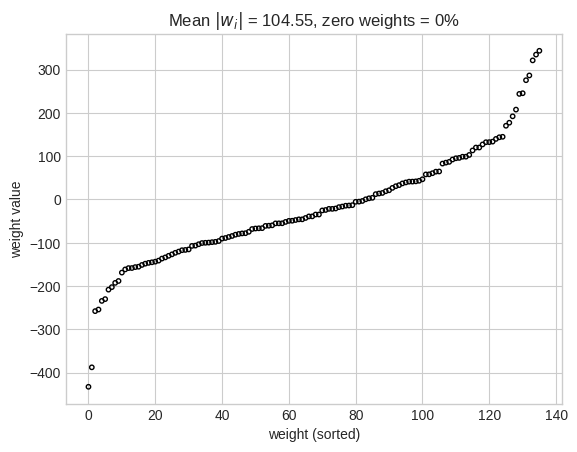

In [23]:
plot_weights(plr)

Yikes! Not only are there *many* weights, but many of them are extremely large.

Can we fix this? In regularization, we add a term to the empirical risk objective function that encourages entries of $\mathbf{w}$ to be small. We  consider the modified objective function
$$
L'(\mathbf{w}) = L(\mathbf{w}) + \lambda R(\mathbf{w})\;,
$$

where $\lambda$ is a *regularization strength* and $R(\mathbf{w})$ is a *regularization function* that aims to shrink the entries of $\mathbf{w}$ in some way. Common choices of regularization function include the $\ell_2$ regularizer, which is simply the square Euclidean norm $R(\mathbf{w}) = \norm{\mathbf{w}}_2^2 = \sum_{j = 1}^p w_i^2$, and the $\ell_1$ norm given by $R(\mathbf{w}) = \sum_{j = 1}^p \abs{w_j}$. To see regularization in action, let's go back to our logistic regression model with a large number of polynomial features. We can see the presence of overfitting in the excessive "wiggliness" of the decision boundary. [If $\mathbf{x}$ is defined in such a way that it has a constant column (e.g. $x_{in} = 1$ for all $n$), then it is important  *not to regularize the entries of $\mathbf{w}$ that correspond to the constant column*. This issue can be avoided by assuming that all the entries of the feature matrix $\Phi(\mathbf{X})$ are column-centered, so that each column mean is zero. This can be achieved simply by defining $\Phi$ that way!]{.aside}

Fortunately for us, we can actually use regularization directly from inside the `scikit-learn` implementation of `LogisticRegression`. Below we specify the penalty (the $\ell_2$ regularization), the strength of the penalty (in the `scikit-learn` implementation, you specify $C = \frac{1}{\lambda}$ so that larger $C$ means less regularization) and the optimization solver (not all solvers work with all penalties).  

This model did much better on the test data than the overfit model.

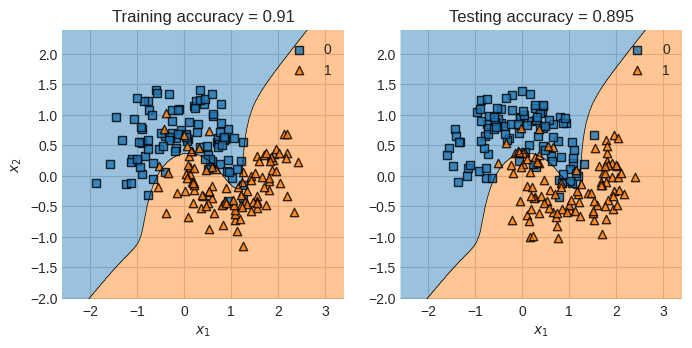

In [24]:
plr = poly_LR(degree = 15, penalty = "l2", solver = "lbfgs")
plr.fit(X_train, y_train)
viz_decision_regions(plr, X_train, y_train, X_test, y_test)

One reason for this success is that the entries of the weight vector are now much smaller:

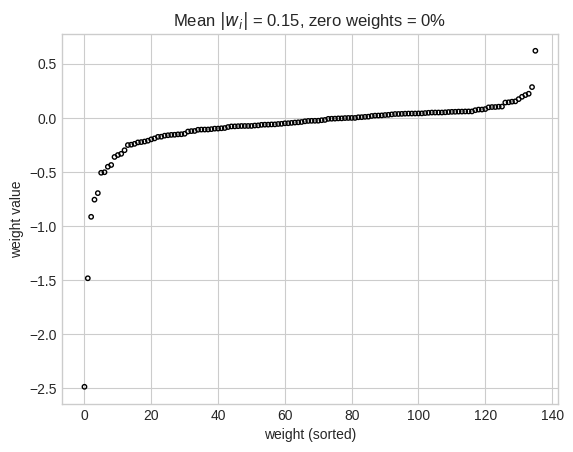

In [25]:
plot_weights(plr)

In fact, we can even force some of the coefficients of the weight vector to be exactly 0. This is achieved through the use of the $\ell_1$ regularization term $R(\mathbf{w}) = \sum_{j = 1}^p \abs{w_j}$.

In [ ]:

viz_decision_regions(plr, X_train, y_train, X_test, y_test)

How do the weights look now?

The benefit of having many weights exactly equal to zero is that it is not necessary to even *compute* the relevant features in order to make a prediction -- we're just going to multiply them by zero later! We often refer to the resulting choices of the parameter vector $\mathbf{w}$ as *sparse*, because most of their entries are zero. Sparsity plays a major role in modern machin elearning.


## Gradients of Regularizers

Suppose that we wish to solve the regularized empirical minimization problem with features:

$$
\begin{aligned}
    \hat{\mathbf{w}} &= L'(\mathbf{w}) \\
              &= \argmin_{\mathbf{w}} L(\mathbf{w}) + \lambda R(\mathbf{w}) \\
              &= \argmin_{\mathbf{w}} \frac{1}{n}\sum_{i = 1}^n \ell(\bracket{\mathbf{w}, \phi(\mathbf{x}_i)}) + \lambda R(\mathbf{w})\;,
\end{aligned}
$$

where $R(\mathbf{w})$ is the regularization term. The gradient of the regularization term. The gradient of this expression is

$$
\begin{aligned}
    \nabla L'(\mathbf{w}) = \nabla L(\mathbf{w}) + \lambda \nabla R(\mathbf{w})\;.  
\end{aligned}
$$
So, to compute the gradient of the regularized empirical risk, we just need the gradient of (a) the standard unregularized empirical risk and the regularization term. Here are two examples of gradients for the regularization term. Suppose that $w_i$ is the coefficient of the constant feature in $\mathbf{w}$, and let $\mathbf{w}_{-i}$ be the vector of entries of $\mathbf{w}$ *excluding $w_i$*. [Usually, data processing pipelines are set up so that $i = 1$ or $i = n$.]{.aside} Then, the gradients for the two most common regularization terms are given by the derivatives:  

$$
\begin{aligned}
    R(\mathbf{w}) &= \lVert \mathbf{w}_{-i} \rVert_2^2 = \sum_{j \neq i} w_j^2\;, &\quad \frac{\partial R(\mathbf{w})}{\partial w_j} &= \begin{cases}
        0 &\quad j = i \\
        2w_j  &\quad j \neq i \end{cases} &\quad \text{($\ell_2$ regularization)} \\
    R(\mathbf{w}) &= \lVert \mathbf{w}_{-i} \rVert_{1} = \sum_{j \neq i} \abs{w_j}\;, &\quad \frac{\partial R(\mathbf{w})}{\partial w_j} &= \begin{cases}
        0 &\quad j = i \\
        \mathrm{sign}(w_j)  &\quad j \neq i, w_j \neq 0 \\
        0  &\quad j \neq i, w_j = 0
         \end{cases} &\quad \text{($\ell_1$ regularization)}
\end{aligned}
$$

*Technically,* the derivative of $\abs{w_j}$ is not defined when $w_j = 0$. It is ok to pretend that it is and equal to zero for the purposes of optimization due to the theory of [subdifferentials](https://en.wikipedia.org/wiki/Subderivative).



## Reflecting on Empirical Risk Minimization

We have now introduced all the fundamental features of modern empirical risk minimization for training machine learning models. We aim to find a weight vector $\hat{\mathbf{w}}$ that solves the problem

$$
\begin{aligned}
    \hat{\mathbf{w}} = \argmin_{\mathbf{w}} \frac{1}{n} \sum_{i = 1}^n \ell (\bracket{\mathbf{w}, \phi(\mathbf{x}_i)}, y_i) + \lambda R(\mathbf{w})\;.
\end{aligned}
$${#eq-regularized-erm}

Until roughly 2005 or so, @eq-regularized-erm was the state of the art for a wide array of classification and regression problems. Common questions would include:

1. What *loss functions* $\ell$ should be used for model scoring?
2. What *feature maps* $\phi$ should be used for extracting useful features from the data?
3. What *regularization terms* should be used to guard against overfitting?

[It's not the case that all of machine learning fit into this framework; important supervised techniques that don't fall into this category include probabilistic machine learning and tree-based methods like decision trees and random forests.]{.aside}

We'll soon study two ways to move past this paradigm: kernel methods and deep learning.
